In [51]:
import pickle,time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.kernel_ridge import KernelRidge

In [52]:
w_t = np.loadtxt("W_milady.snapcoeff",skiprows=6)
print(w_t.size)
num_desc = 55

56


In [63]:
class LinearSolve:
    def __init__(self):
        self.Theta = None
    def fit(self,A,t,w):
        self.Theta = np.linalg.solve(A.T@np.diag(w)@A,A.T@np.diag(w)@t)
    def predict(self,A):
        return A@self.Theta

def line(v):
    l = np.linspace(v.min(),v.max(),11)
    return l,l

def jmax_select_vector(twojmax=8,quad=False):
    sel = np.zeros((56),bool)
    assert twojmax<=8 and twojmax%2==0
    sel[0] = True
    c = 0
    for j1 in range(0,twojmax+1):
        for j2 in range(0,j1+1):
            for j in range(j1-j2,min(twojmax,j1+j2)+1,2):
                if (j>=j1): 
                    sel[c+1] = True
                    c+=1
    if quad:
        quad_sel = np.outer(sel[1:],sel[1:])[np.triu_indices(sel.size-1)]
        sel = np.append(sel.copy(),quad_sel)                                     
    return sel

def load_data(pkl_file,num_desc=56,quad=True):
    if quad:
        num_desc += ((num_desc-1)*num_desc)//2
    data = pickle.load(open(pkl_file,"rb"))
    for f in ['A','a','t']:
        data[f] = np.array(data[f])
    data['A'] = data['A'].reshape((data['a'].size,-1))
    data['A'] = data['A'][:,:num_desc]
    data['is_energy'] = np.array(data['is_energy'],bool).flatten()
    data['is_minima'] = np.array(data['is_minima'],bool).flatten()
    return data.copy()    

def plot_results(axs,d,sel,fit_mask):
    A = d['A'][:,sel]
    t = d['t']
    a = d['a']
    a_energies = a[d['is_energy']]
    A_energies = A[d['is_energy']]
    t_energies = t[d['is_energy']]
    
    A_forces = A[~d['is_energy']]
    t_forces = t[~d['is_energy']]
    
    
    A_fit = A[fit_mask]
    t_fit = t[fit_mask]
    w_fit = np.where(d['is_energy'],1.0,0.0001)[fit_mask]
    W_fit = np.diag(w_fit)
    
    e_fit_mask = d['is_energy'] * fit_mask
    f_fit_mask = ~d['is_energy'] * fit_mask
    
    
    dt = -time.time()
    Solve = LinearSolve()
    Solve.fit(A_fit,t_fit,w_fit)
    dt += time.time()
    print("Solve fit took %2.2gs" % dt)
    
    dt = -time.time()
    Ridge = BayesianRidge()
    Ridge.fit(A_fit,t_fit,w_fit)
    dt += time.time()
    print("Ridge fit took %2.2gs" % dt)
    
    dt = -time.time()
    Kernel = KernelRidge()
    Kernel.fit(A_fit[d['is_energy'][fit_mask]],t_fit[d['is_energy'][fit_mask]],w_fit[d['is_energy'][fit_mask]])
    dt += time.time()
    print("Kernel fit took %2.2gs" % dt)
    
    
        
    plt_data = lambda ax,x,y,l,u="eV": ax.plot(x,y,'.',label=l+" %2.2g m" % (1000.0*np.abs(x-y).mean())+u)
    is_minima = d['is_energy']
    
    axs[0].plot(a[is_minima],t[is_minima],'ko')
    
    axs[0].plot(a[is_minima],Solve.predict(A[is_minima]),'.',label="Solve")
    axs[0].plot(a[is_minima],Ridge.predict(A[is_minima]),'.',label="Ridge")
    axs[0].plot(a[is_minima],Kernel.predict(A[is_minima]),'.',label="Kernel")
    
    axs[0].legend(fontsize=8)
    dE = t[is_minima].max()-t[is_minima].min()
    axs[0].set_ylim(t[is_minima].min() - dE*0.5 ,t[is_minima].max() + dE*0.5)
    
    axs=axs[1:]
    axs[0].plot(*line(t_energies),'k--')
    plt_data(axs[0],t[e_fit_mask],Solve.predict(A[e_fit_mask]),l="Solve")
    plt_data(axs[0],t[e_fit_mask],Ridge.predict(A[e_fit_mask]),l="Ridge")
    plt_data(axs[0],t[e_fit_mask],Kernel.predict(A[e_fit_mask]),l="Kernel")
    axs[0].legend(fontsize=8)
    axs[0].set_xlim(t_energies.min(),t_energies.max())
    axs[0].set_ylim(t_energies.min(),t_energies.max())
    
    axs[1].plot(*line(t_energies),'k--')
    plt_data(axs[1],t_energies,Solve.predict(A_energies),l="Solve")
    plt_data(axs[1],t_energies,Ridge.predict(A_energies),l="Ridge")
    plt_data(axs[1],t_energies,Kernel.predict(A_energies),l="Kernel")
    axs[1].legend(fontsize=8)
    axs[1].set_xlim(t_energies.min(),t_energies.max())
    axs[1].set_ylim(t_energies.min(),t_energies.max())
    
    
    axs[2].plot(*line(t_forces),'k--')
    plt_data(axs[2],t[f_fit_mask],Solve.predict(A[f_fit_mask]),l="Solve",u="eV/A")
    plt_data(axs[2],t[f_fit_mask],Ridge.predict(A[f_fit_mask]),l="Ridge",u="eV/A")
    axs[2].legend(fontsize=8)
    axs[2].set_xlim(t_forces.min(),t_forces.max())
    axs[2].set_ylim(t_forces.min(),t_forces.max())
    
    axs[3].plot(*line(t_forces),'k--')
    plt_data(axs[3],t_forces,Solve.predict(A_forces),l="Solve",u="eV/A")
    plt_data(axs[3],t_forces,Ridge.predict(A_forces),l="Ridge",u="eV/A")
    axs[3].legend(fontsize=8)
    axs[3].set_xlim(t_forces.min(),t_forces.max())
    axs[3].set_ylim(t_forces.min(),t_forces.max())
    
    

In [54]:
data = load_data("Training_Data_Bulk_Small.pkl",quad=False)
data_quad = load_data("Training_Data_Bulk_Small.pkl",quad=True)

In [64]:
fit_mask = np.random.uniform(size=data['is_energy'].size)<0.05
print(fit_mask.sum())

203


Solve fit took 0.00065s
Ridge fit took 0.0034s
Kernel fit took 0.00039s
Solve fit took 0.0079s
Ridge fit took 0.017s
Kernel fit took 0.00087s
Solve fit took 0.00039s
Ridge fit took 0.0043s
Kernel fit took 0.00053s
Solve fit took 0.11s
Ridge fit took 0.062s
Kernel fit took 0.0012s


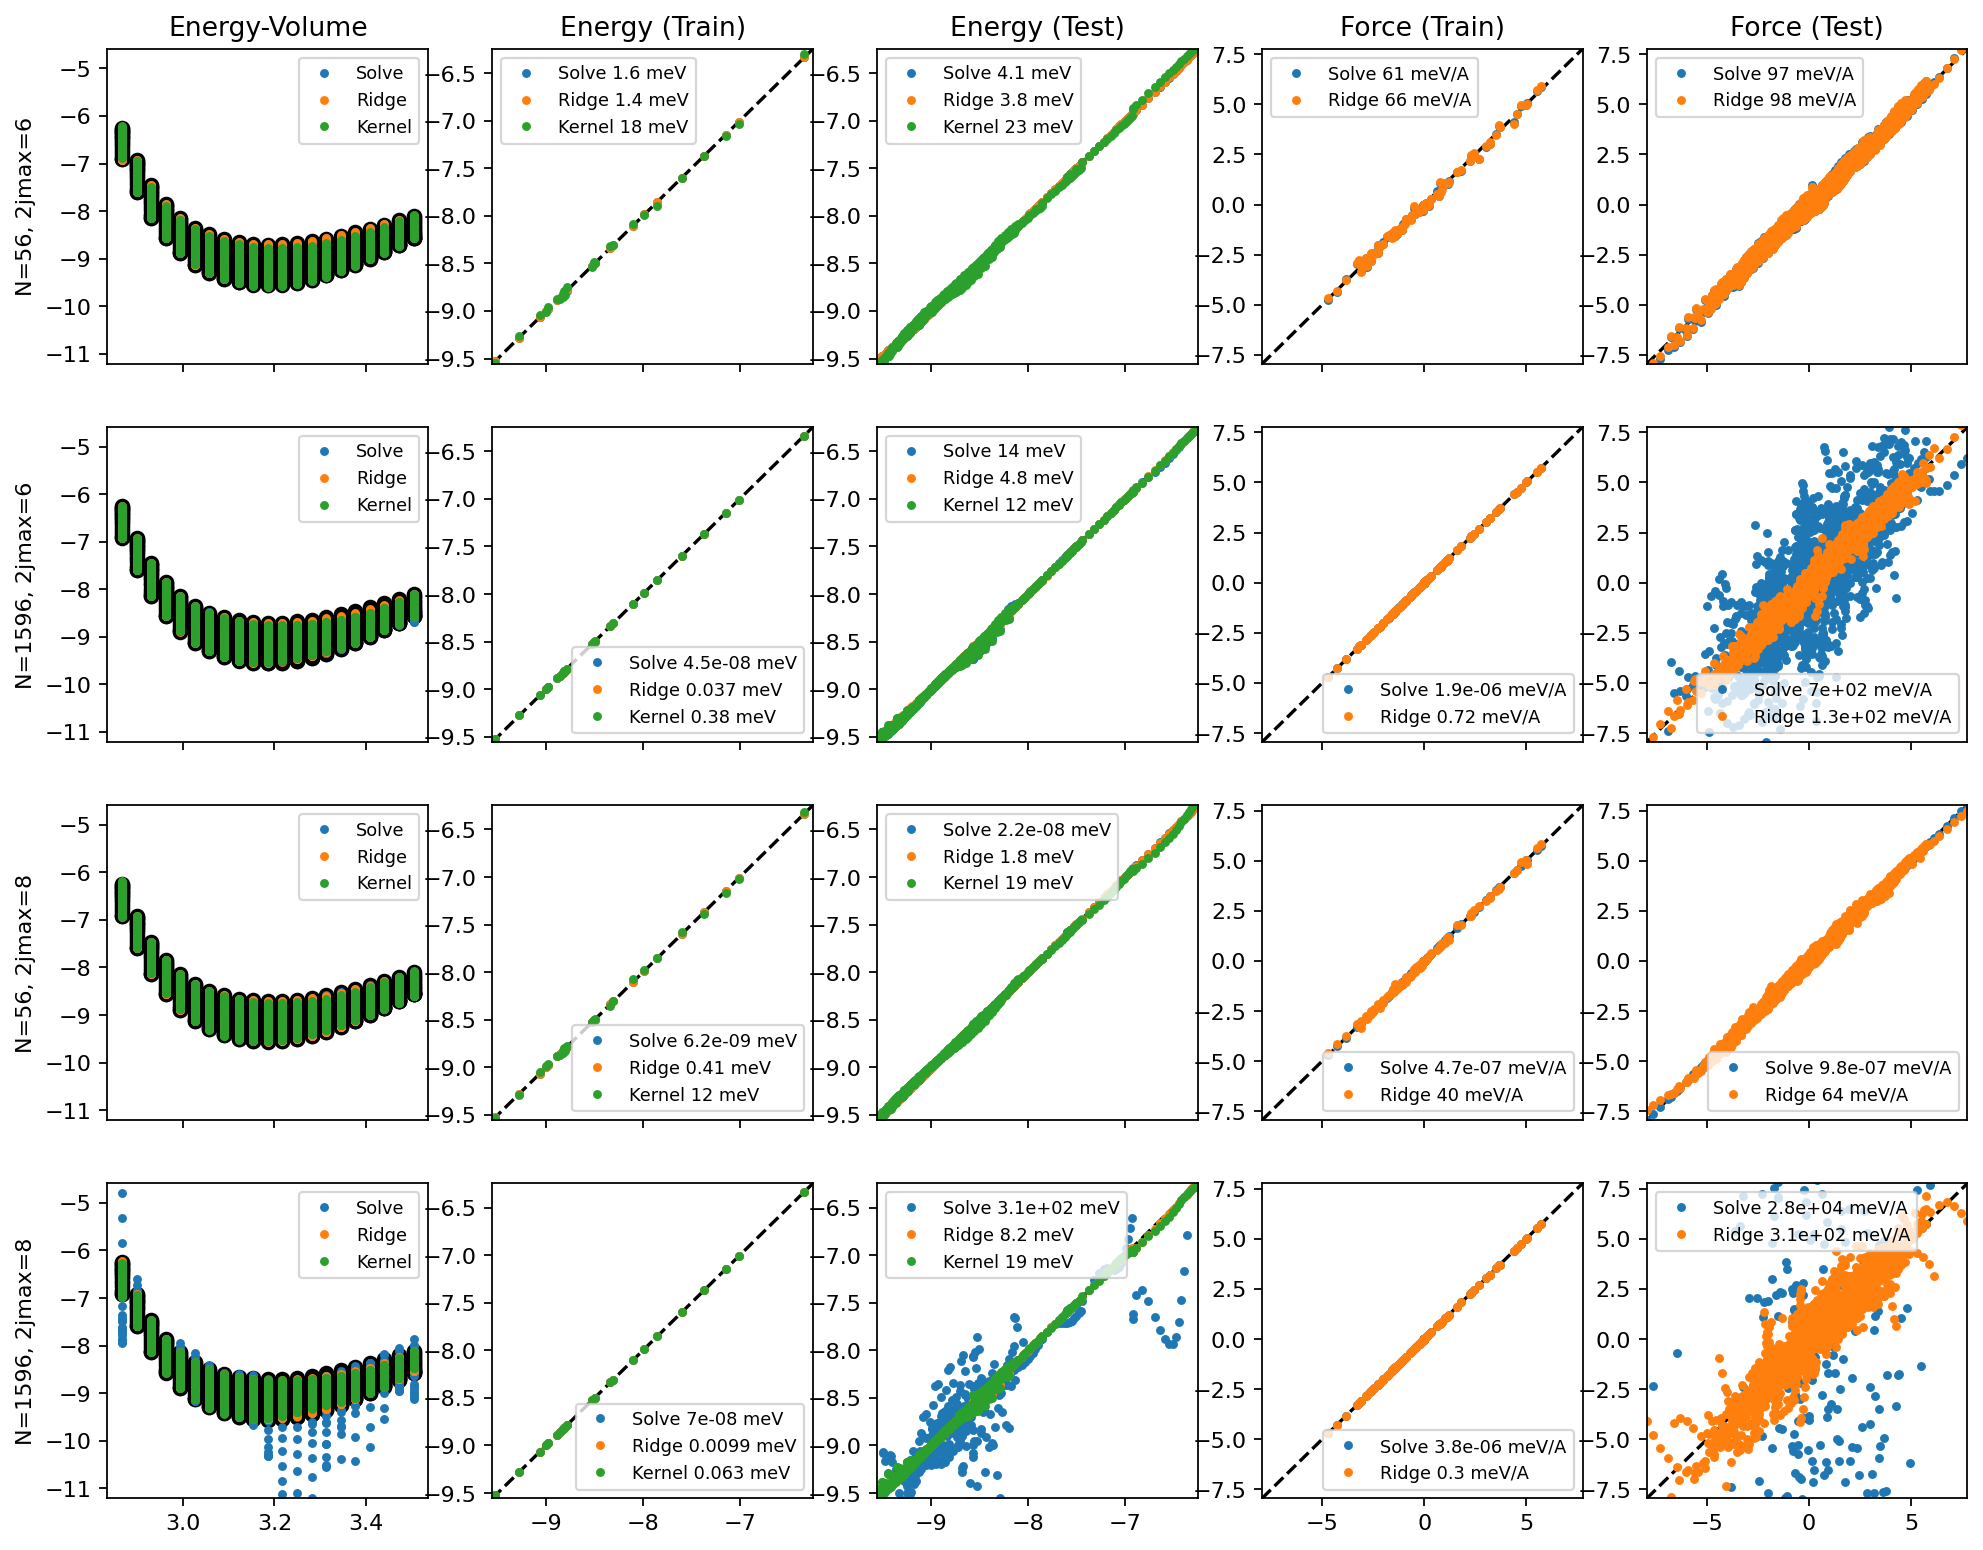

In [65]:
fig,axs = plt.subplots(4,5,figsize=(15,12),sharex='col',sharey='col',dpi=160)

axs[0,0].set_title("Energy-Volume")
axs[0,1].set_title("Energy (Train)")
axs[0,2].set_title("Energy (Test)")
axs[0,3].set_title("Force (Train)")
axs[0,4].set_title("Force (Test)")
for i,twojmax_quad in enumerate(zip([6,6,8,8],[False,True,False,True])):
    sel = jmax_select_vector(twojmax_quad[0],quad=twojmax_quad[1])
    d = [data,data_quad][twojmax_quad[1]]
    plot_results(axs[i],d,sel,fit_mask)
    
    axs[i,0].set_ylabel(f"N={d['A'].shape[1]}, 2jmax={twojmax_quad[0]}")
    